In [1]:
# Loading packages
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import statsmodels
from scipy import stats

In [2]:
start = '2018-04-01' # start date of time series
today = '2021-04-01' # end date of time series

# SWI20 (yahoo) tickers
swi = ['SGSN.SW','SCMN.SW','GIVN.SW','ZURN.SW','NOVN.SW',
          'ROG.SW','CSGN.SW','LHN.SW','ABBN.SW','UHR.SW',
          'LONN.SW','SLHN.SW','PGHN.SW','GEBN.SW','NESN.SW',
          'SREN.SW','CFR.SW','UBSG.SW','SIKA.SW','ALC.SW']

# Names of those SWI firms
swi_names = ['SGS','Swisscom','Givaudan','Zurich Insurance Group','Novartis',
         'Roche','Credit Suisse','LafargeHolcim','ABB','Swatch Group',
         'Lonza','Swiss Life Holding','Partners Group','Geberit','Nestle',
         'Swiss Re','Richemont','UBS','Sika','Alcon']

# more_ticks = ['ADEN.SW','BAER.SW','CLN.SW','GIVN.SW','KNIN.SW','SOON.SW']
# more_names = ['Adecco Group','Julius Bär','Clariant','Givaudan','Kuehne + Nagel International','Sonova']

In [3]:
# Fetch daily price and volume data from yahoo; calculate log prices
def get_data(ticks,start_date,end_date):    
    prices = []
    for i in ticks:
        closing = pdr.DataReader(i,
                                 data_source='yahoo',
                                 start=start_date,
                                 end=end_date
                                ).iloc[:,-1]
        prices.append(closing)

    prices = pd.concat(prices,axis=1)
    prices.columns = ticks
    prices_logs = np.log(prices/prices.shift(1))

    volumes = []
    for i in ticks:
        vol = pdr.DataReader(i,
                                 data_source='yahoo',
                                 start=start_date,
                                 end=end_date
                                ).iloc[:,-2]
        volumes.append(vol)

    volumes = pd.concat(volumes,axis=1)
    volumes.columns = ticks
    
    return prices, prices_logs, volumes

# Calculate ADTV and sort them by value - last month
def ADTV(volumes):
    adtv = pd.DataFrame(data=[volumes.iloc[-20:,:].mean(),
                              volumes.iloc[-250*3:,:].mean()],
                        index=['Last month','Last three years']) \
                        .transpose()
    adtv_sorted = adtv.sort_values(by='Last month',ascending=False)
    return adtv_sorted

# Plot prices or volumes
def plot_volumes(prices):
    tcks = prices.columns
    fig, ax = plt.subplots(nrows=len(tcks),ncols=1,
                           figsize=[16,9*2],dpi=100)
    for i in range(len(tcks)):
        ax[i].plot(prices.iloc[:,i])
        ax[i].set_title(tcks[i])
    plt.tight_layout()
    
# Plot log prices
def plot_volatility(logprices):
    tcks = logprices.columns
    fig, ax = plt.subplots(nrows=len(tcks),ncols=1,
                           figsize=[16,9*2],dpi=100)
    for i in range(len(tcks)):
        ax[i].plot(logprices.iloc[:,i])
        ax[i].axhline(y=0,c='k')
        ax[i].set_title(tcks[i])
    plt.tight_layout()
    
# Lending Value (not adjusted)
def LV(log_prices,alpha,epsilon,delta):
    mu = log_prices.mean()
    sigma = log_prices.std()
    drift = (mu-sigma**2/2)*delta
    diffusion = sigma**2*delta
    lv = ( (1-alpha)*(np.exp(drift+sigma*np.sqrt(delta)*stats.norm.ppf(epsilon))) ) / \
    ( 1-alpha*(np.exp(drift+sigma*np.sqrt(delta)*stats.norm.ppf(epsilon))) )
    return lv

# Lending Value adjusted for liquidity -- to do
def LV_adj(log_prices,alpha,epsilon,delta):
    mu = log_prices.mean()
    sigma = log_prices.std()
    drift = (mu-sigma**2/2)*delta
    diffusion = sigma**2*delta
    x = 0
    gamma = 0
    lv_adj = 0
    return lv_adj

In [4]:
# SWI stocks prices for the last 3 years
prices_swi = get_data(swi,start,today)[0]
# Same but log prices
logprices_swi = get_data(swi,start,today)[1]
# Same but volume
volumes_swi = get_data(swi,start,today)[2]

In [5]:
prices_swi

,SGSN.SW,SCMN.SW,GIVN.SW,ZURN.SW,NOVN.SW,ROG.SW,CSGN.SW,LHN.SW,ABBN.SW,UHR.SW,LONN.SW,SLHN.SW,PGHN.SW,GEBN.SW,NESN.SW,SREN.SW,CFR.SW,UBSG.SW,SIKA.SW,ALC.SW
Date,,,,,,,,,,,,,,,,,,,,
2018-04-03,2109.201904,405.845978,2032.542114,258.951904,60.724892,196.694016,14.082186,43.794113,18.626474,388.202332,215.105362,287.630096,643.263855,386.598572,68.466255,80.018456,79.870483,12.491334,118.439026,NaN
2018-04-04,2100.118652,406.283020,2008.121704,258.617859,60.756592,195.372406,13.810002,43.455940,18.279289,387.647339,214.131165,283.900177,635.052063,383.457001,68.300575,76.930611,79.682999,12.249225,116.284149,NaN
2018-04-05,2148.261230,413.800293,2065.416260,259.703430,62.181320,199.200546,14.189275,44.910107,18.930262,398.746796,223.288712,286.951965,643.720093,392.050140,69.607674,78.026299,80.901688,12.619954,119.316307,NaN
2018-04-06,2141.902832,413.433624,2075.747803,264.223877,61.484814,197.970062,13.984022,44.690292,18.669872,397.544312,221.924820,288.647400,639.614136,391.576538,69.939056,78.109291,80.489212,12.498900,117.640282,NaN
2018-04-09,2148.261230,413.250275,2075.747803,263.692047,61.405659,198.289078,14.010795,44.555016,18.869505,399.394226,221.437729,289.071259,642.807617,391.765991,69.957466,78.955963,81.651634,12.544294,117.321358,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,2666.000000,505.200012,3567.000000,402.100006,81.879997,303.649994,12.470000,55.020000,28.490002,268.200012,548.599976,465.399994,1220.500000,594.599976,104.139999,93.720001,89.739998,15.125000,265.500000,65.239998
2021-03-29,2704.000000,508.200012,3611.000000,405.399994,82.379997,304.500000,10.745000,55.119999,28.440001,269.200012,544.200012,465.899994,1200.000000,600.000000,105.220001,94.239998,90.379997,14.535000,266.100006,65.059998
2021-03-30,2720.000000,507.600006,3618.000000,410.100006,81.860001,303.850006,10.415000,56.060001,28.520000,278.000000,528.599976,470.200012,1220.500000,605.000000,105.940002,94.559998,92.580002,14.690000,268.600006,66.599998


In [6]:
ADTV(volumes_swi)

,Last month,Last three years
ABBN.SW,8.087069e+10,2.166924e+09
ROG.SW,8.086622e+10,2.161113e+09
CSGN.SW,9.938054e+07,1.470502e+07
UBSG.SW,9.515793e+07,1.885247e+07
NOVN.SW,8.658420e+07,8.005005e+06
NESN.SW,8.564973e+07,7.927945e+06
LHN.SW,8.277175e+07,4.741750e+06
CFR.SW,8.220394e+07,4.234490e+06
SREN.SW,8.211077e+07,3.769937e+06
ALC.SW,8.180533e+07,5.075038e+06


In [8]:
# Select the most liquid, 5th liquid, 10th liquid, 16th liquid and the least liquid stock in the SMI index
selection = [0,4,9,15,19]
ADTV(volumes_swi).iloc[selection,:]

selected_ticks = list(ADTV(volumes_swi).iloc[selection,:].index)
selected_prices = prices_swi[selected_ticks]
selected_logprices = logprices_swi[selected_ticks]
selected_volumes = volumes_swi[selected_ticks]

### Descriptive stats for price time series of selected stocks

In [9]:
selected_prices.describe()
# only 2 years of data for ALC.SW

,ABBN.SW,NOVN.SW,ALC.SW,SLHN.SW,SGSN.SW
count,751.000000,751.000000,498.000000,751.000000,752.000000
mean,19.590228,75.141898,57.358657,381.875699,2333.187197
std,2.908049,7.650361,4.359203,61.027991,158.022211
min,13.474856,57.321438,38.714115,246.679886,1850.626587
25%,17.102008,69.364712,55.210001,326.551147,2228.188293
50%,19.346886,77.344048,57.754824,371.100006,2330.145874
75%,21.611763,80.555790,59.569906,442.795135,2414.533203
max,28.790001,88.942284,68.480003,492.792725,2720.000000


### Plots: price, volatility and volume time series

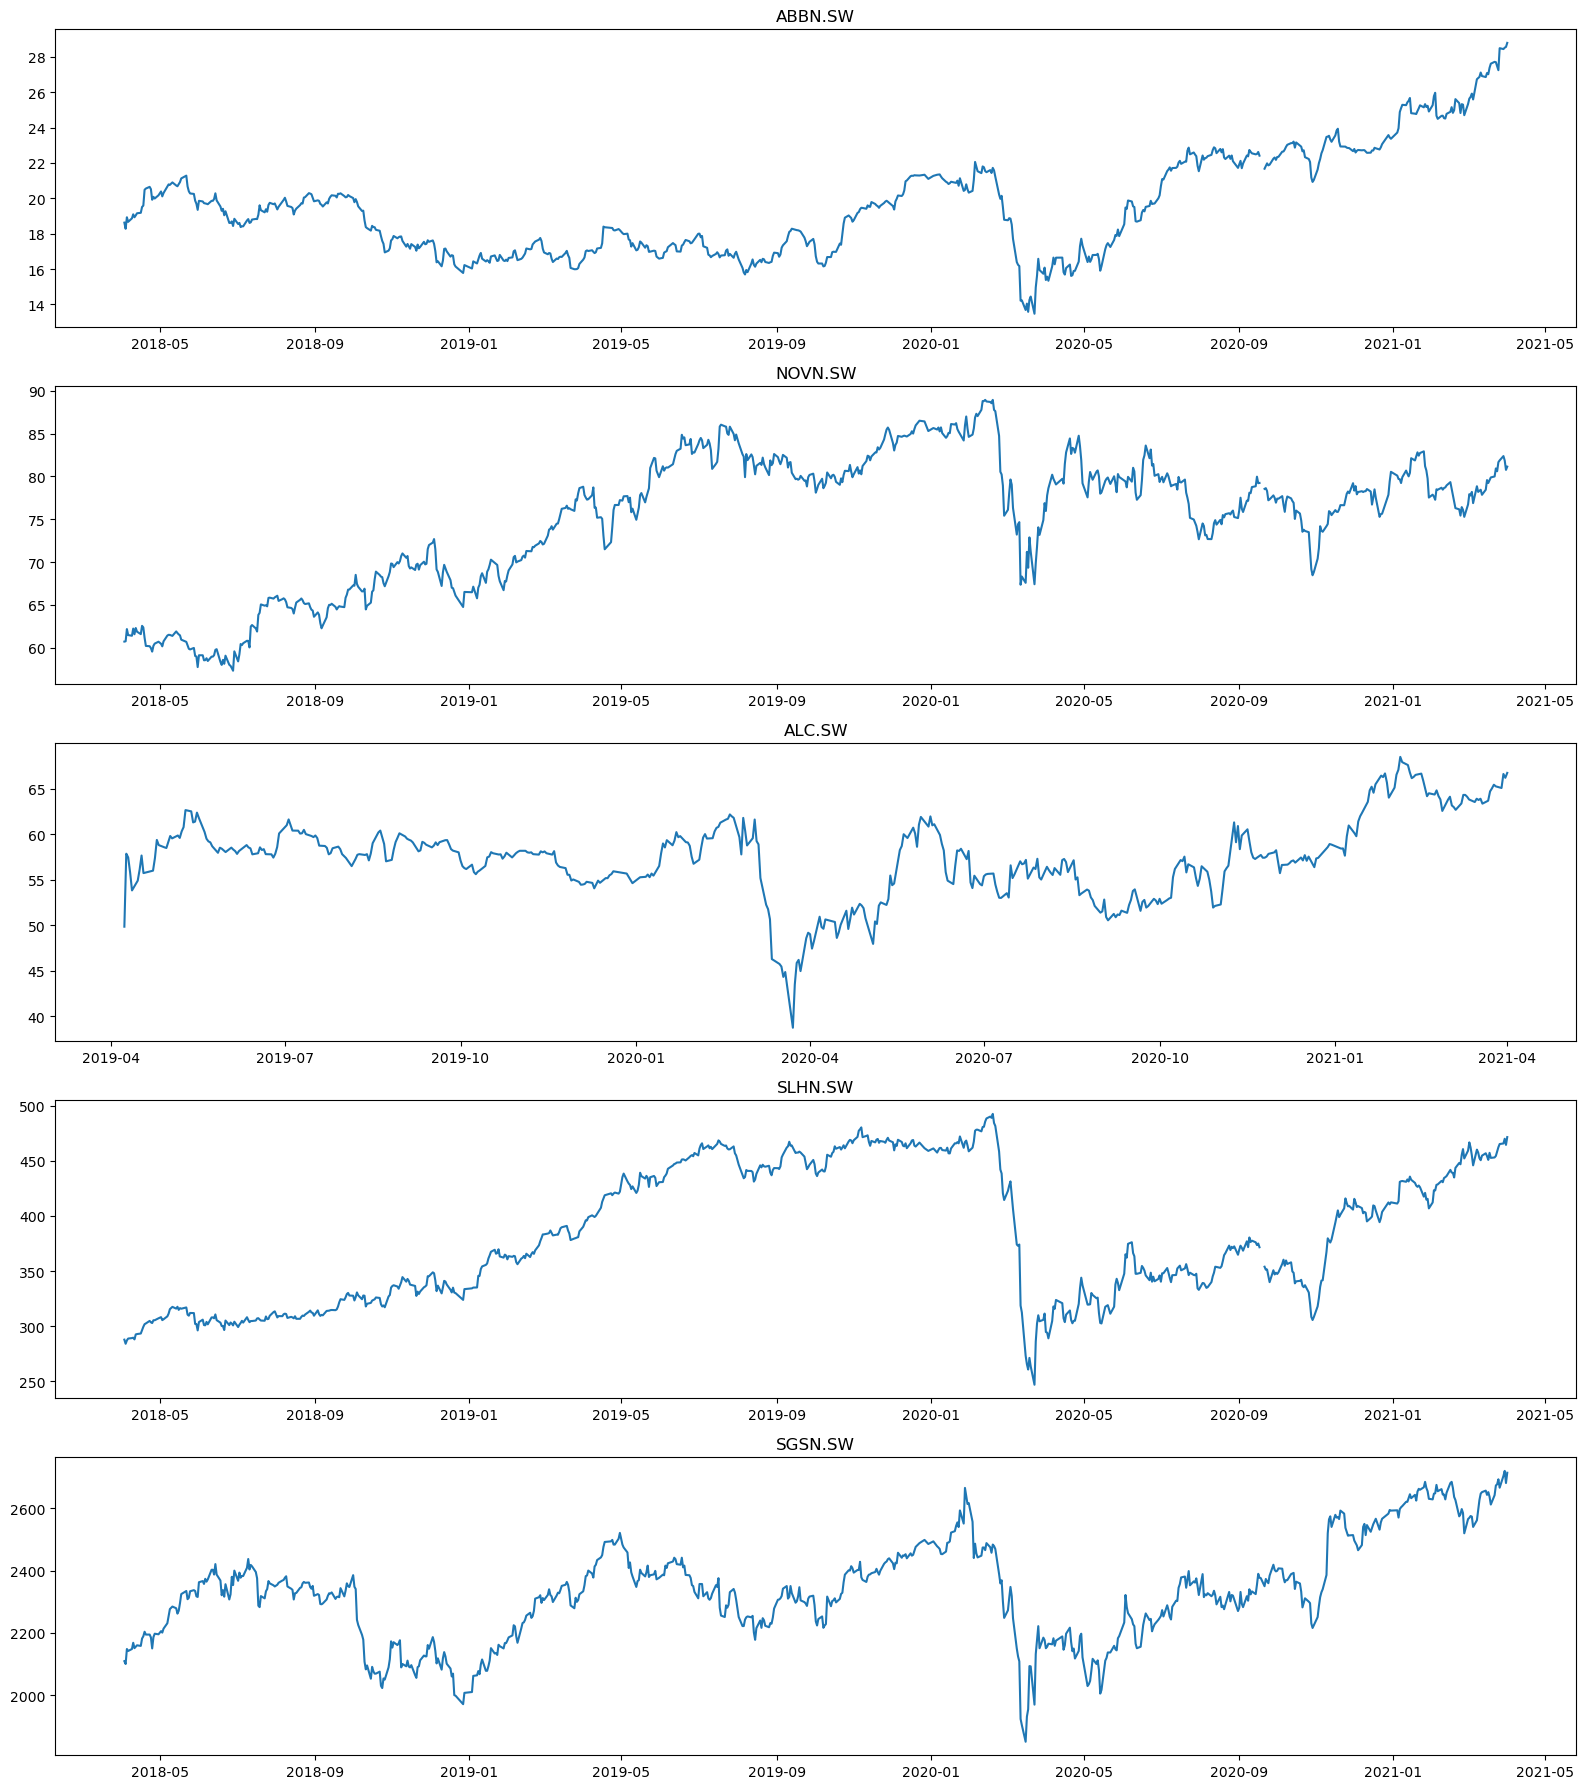

In [10]:
# Stock price time series
plot_volumes(selected_prices)

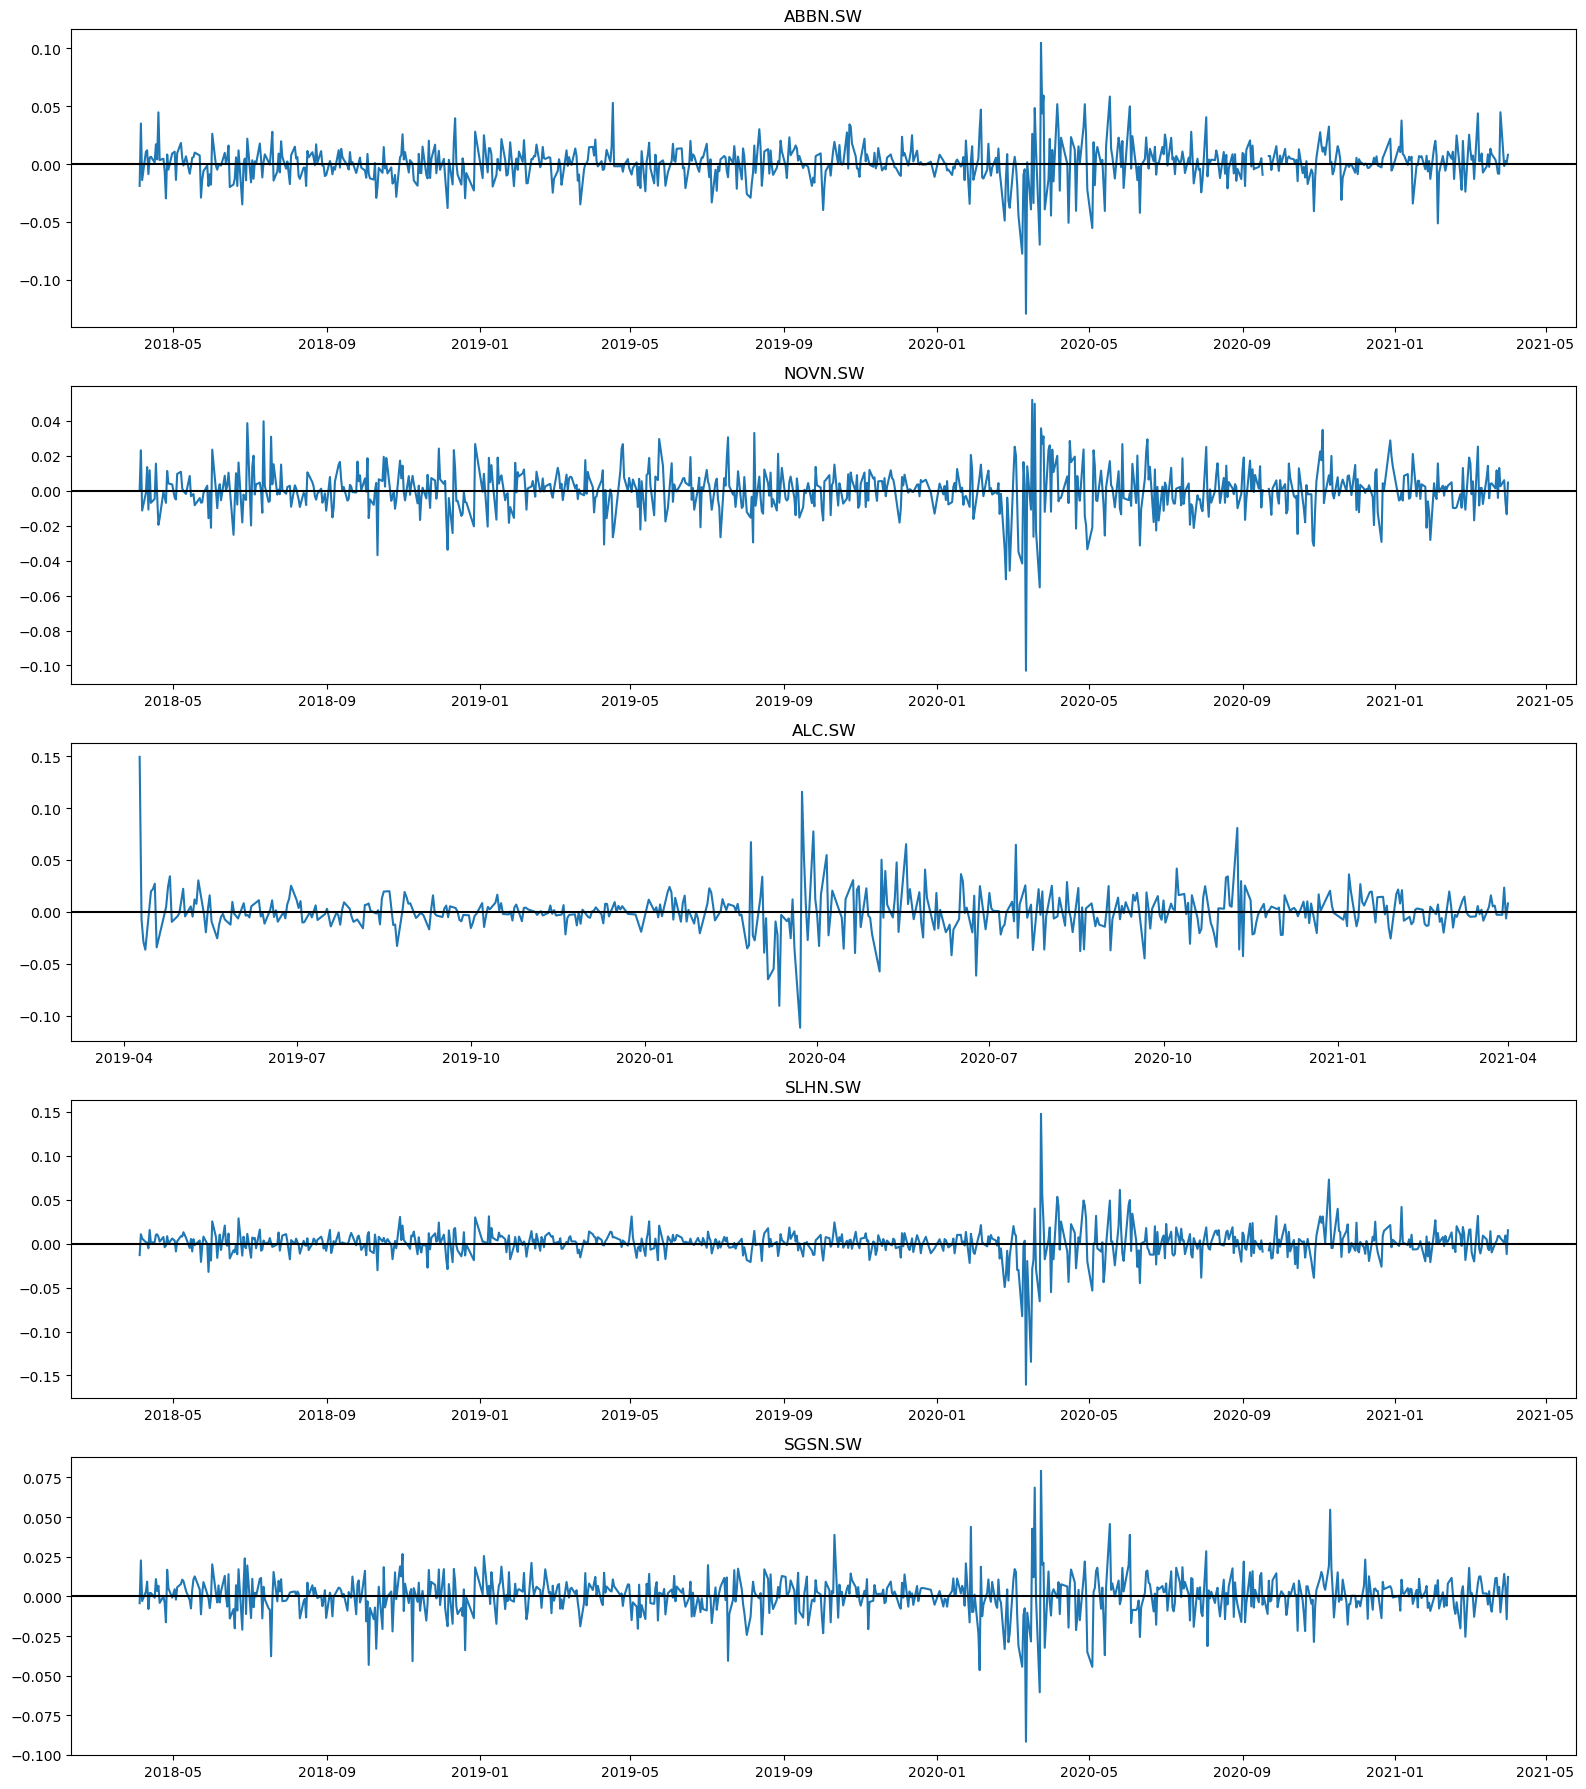

In [11]:
# Stock volatility time series
plot_volatility(selected_logprices)

In [12]:
selected_volumes

,ABBN.SW,NOVN.SW,ALC.SW,SLHN.SW,SGSN.SW
Date,,,,,
2018-04-03,1.037490e+07,4.917831e+06,NaN,1.686420e+05,3.063300e+04
2018-04-04,1.198510e+07,5.049773e+06,NaN,2.671630e+05,2.372600e+04
2018-04-05,1.143230e+07,5.258449e+06,NaN,2.139600e+05,1.989100e+04
2018-04-06,9.885968e+06,3.784474e+06,NaN,2.402690e+05,1.747900e+04
2018-04-09,7.488325e+06,3.611290e+06,NaN,1.324660e+05,1.115100e+04
...,...,...,...,...,...
2021-03-26,6.139626e+06,5.953726e+06,1.018582e+06,1.246560e+05,2.169600e+04
2021-03-29,5.205430e+06,3.784753e+06,8.596930e+05,1.180340e+05,2.141200e+04
2021-03-30,4.266746e+06,3.205627e+06,9.863660e+05,1.208650e+05,1.609000e+04


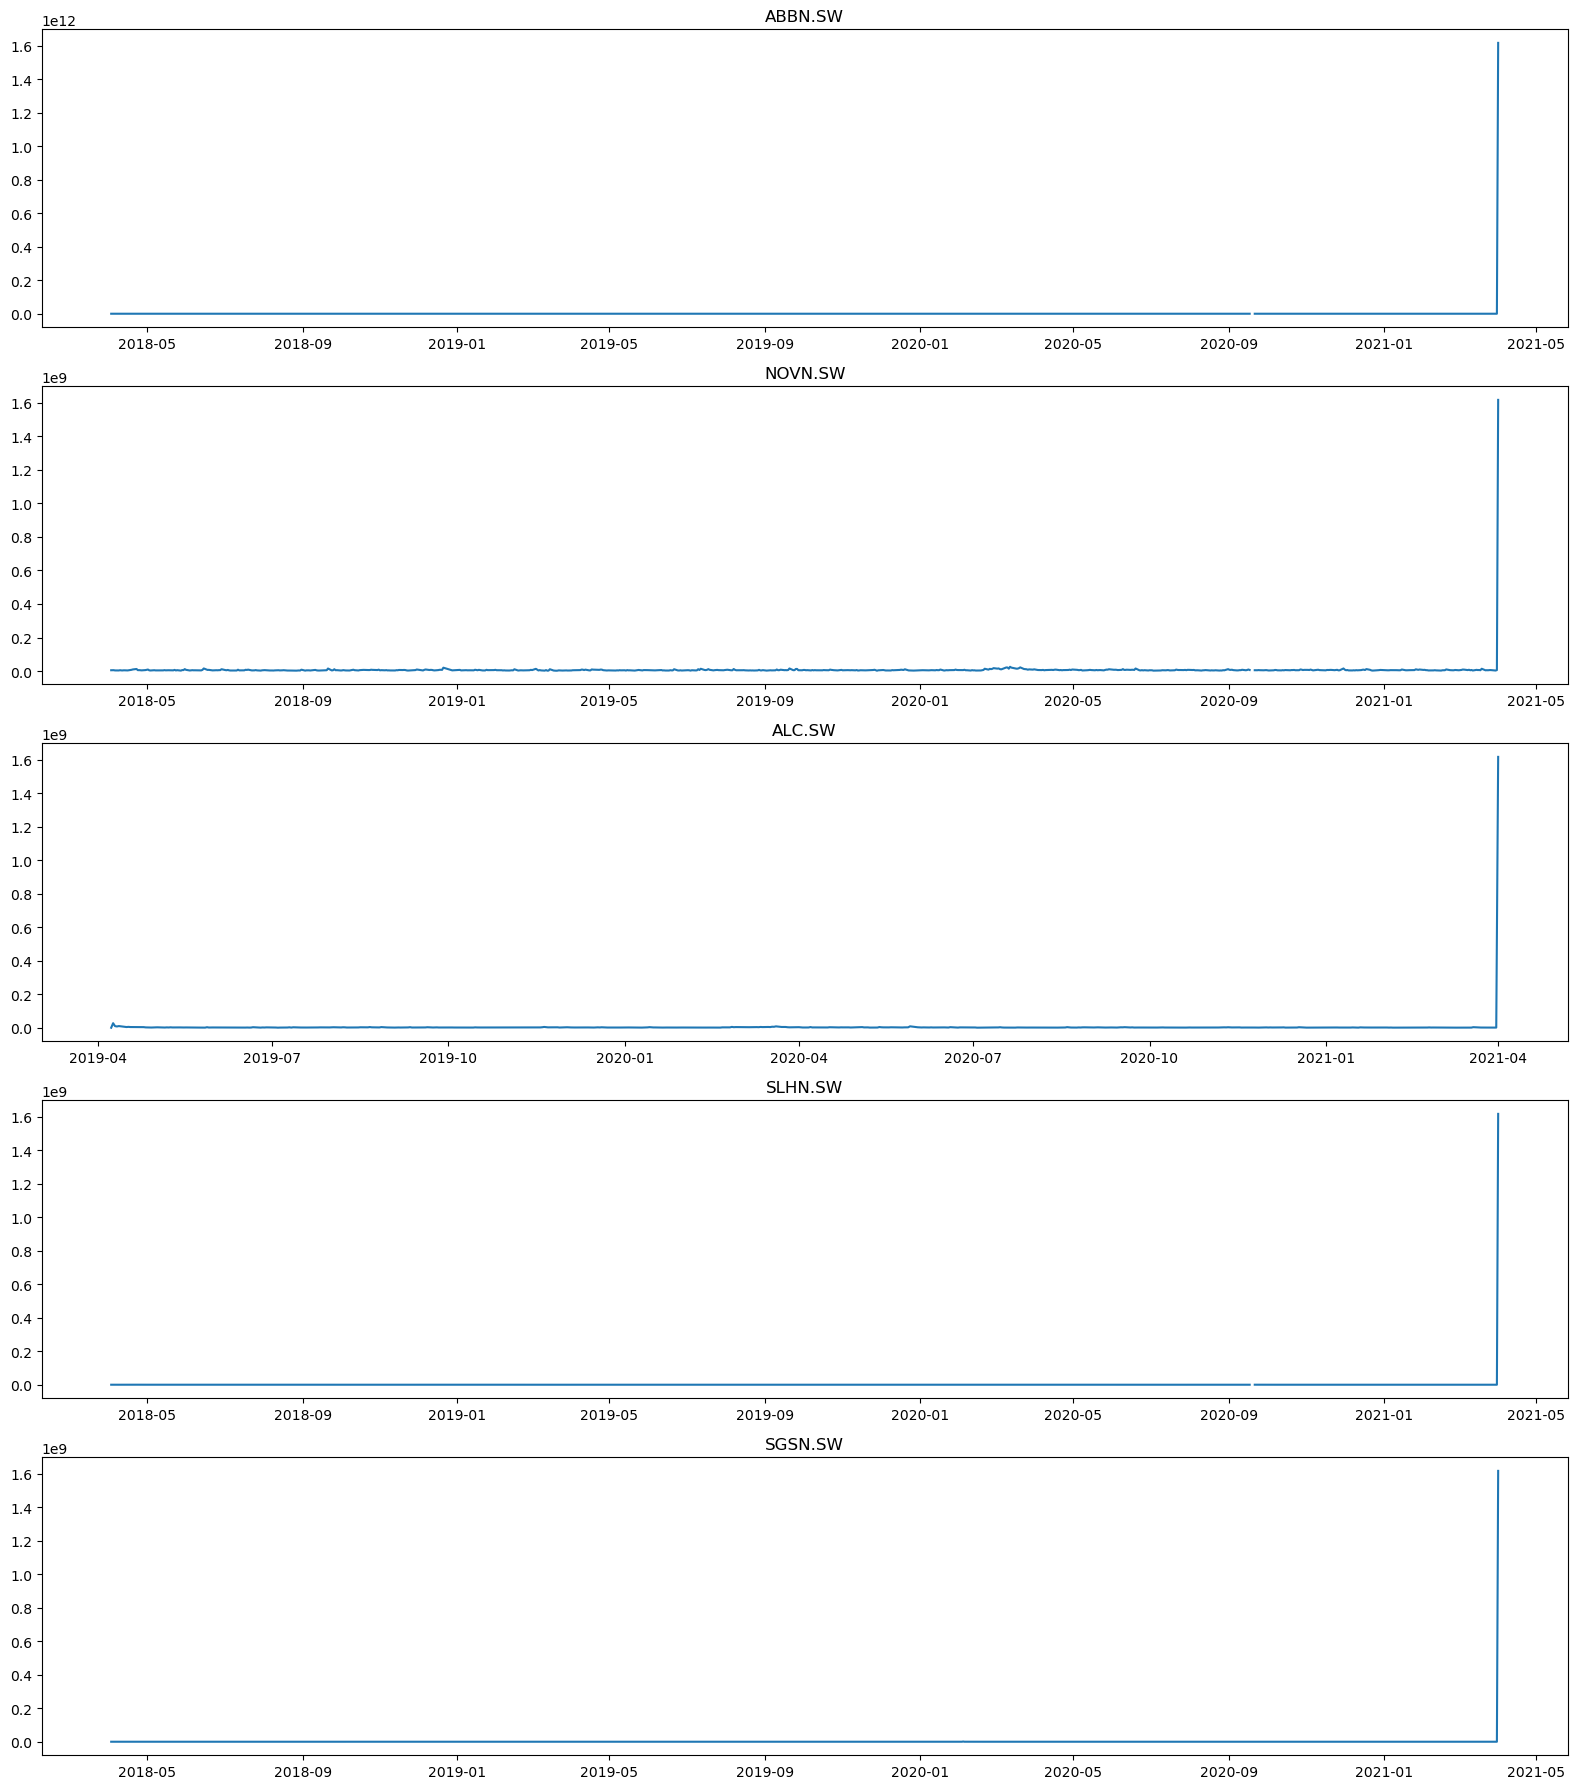

In [13]:
# Stock trading volume time series
plot_volumes(selected_volumes)

## Model

In [14]:
# Parameters
alpha = 0.25
epsilon = 0.01
delta = 10

### SMI

In [16]:
smi_lvs = []
for i in range(len(logprices_swi.columns)):
    lv = LV(logprices_swi.iloc[:,i],alpha,epsilon,delta)
    smi_lvs.append(lv)
smi_lvs = pd.DataFrame(smi_lvs,index=swi)
smi_lvs.columns = ['Lending Value']

smi_lvs

,Lending Value
SGSN.SW,0.885748
SCMN.SW,0.897769
GIVN.SW,0.895014
ZURN.SW,0.866621
NOVN.SW,0.886950
ROG.SW,0.886033
CSGN.SW,0.795574
LHN.SW,0.846930
ABBN.SW,0.857945
UHR.SW,0.826485


In [17]:
# LV for selected stocks
smi_lvs.loc[selected_ticks,:].sort_values(by='Lending Value',ascending=False)

,Lending Value
NOVN.SW,0.886950
SGSN.SW,0.885748
ABBN.SW,0.857945
SLHN.SW,0.854367
ALC.SW,0.824323


### Tesla

In [18]:
tsla_logs = get_data(['TSLA'],start,today)[1]

tsla_lv = LV(tsla_logs,alpha,epsilon,delta)
print('Lending Value for Tesla stock collateral: '+str(tsla_lv[0].round(2)))

Lending Value for Tesla stock collateral: 0.68


---
---
## Hubert's todo

- Adjust the model for liquidity
- Model the lombard process
- CAPM
- VaR and ES
- Backtesting
- Other papers